<a href="https://colab.research.google.com/github/Andyqballer/EV-Detection/blob/main/EVDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1517/1517 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 1.1551 - mean_squared_error: 1.1551 - val_loss: 0.4022 - val_mean_squared_error: 0.4022
Epoch 2/150
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.2563 - mean_squared_error: 0.2563 - val_loss: 0.1969 - val_mean_squared_error: 0.1969
Epoch 3/150
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.1723 - mean_squared_error: 0.1723 - val_loss: 0.1071 - val_mean_squared_error: 0.1071
Epoch 4/150
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.1254 - mean_squared_error: 0.1254 - val_loss: 0.0957 - val_mean_squared_error: 0.0957
Epoch 5/150
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.1342 - mean_squared_error: 0.1342 - val_loss: 0.1076 - val_mean_squared_error: 0.1076
Epoch 6/150
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0824 - mean_squared_error: 0.0824 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 7/150
1517/1517 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0743 - mean_squared_error: 0.0743 

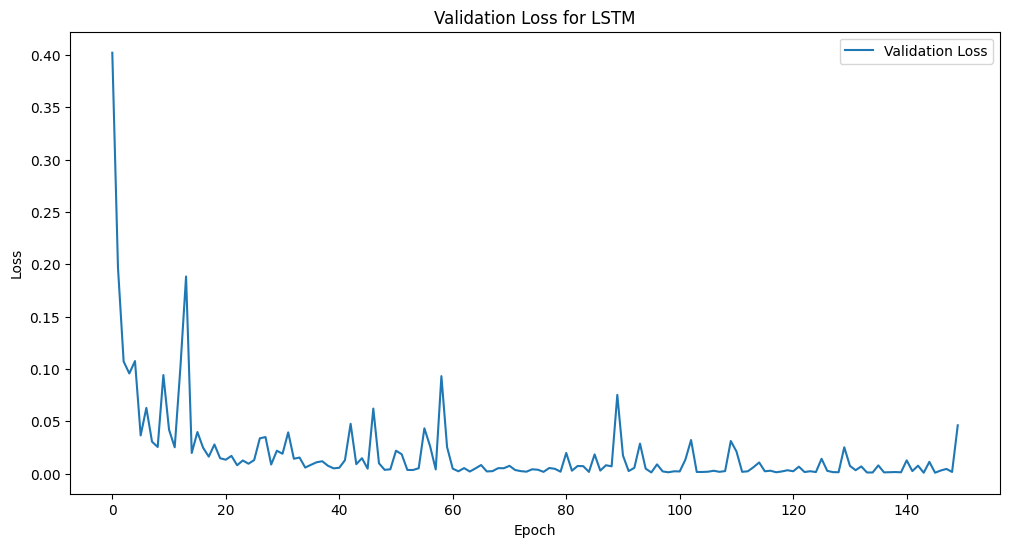

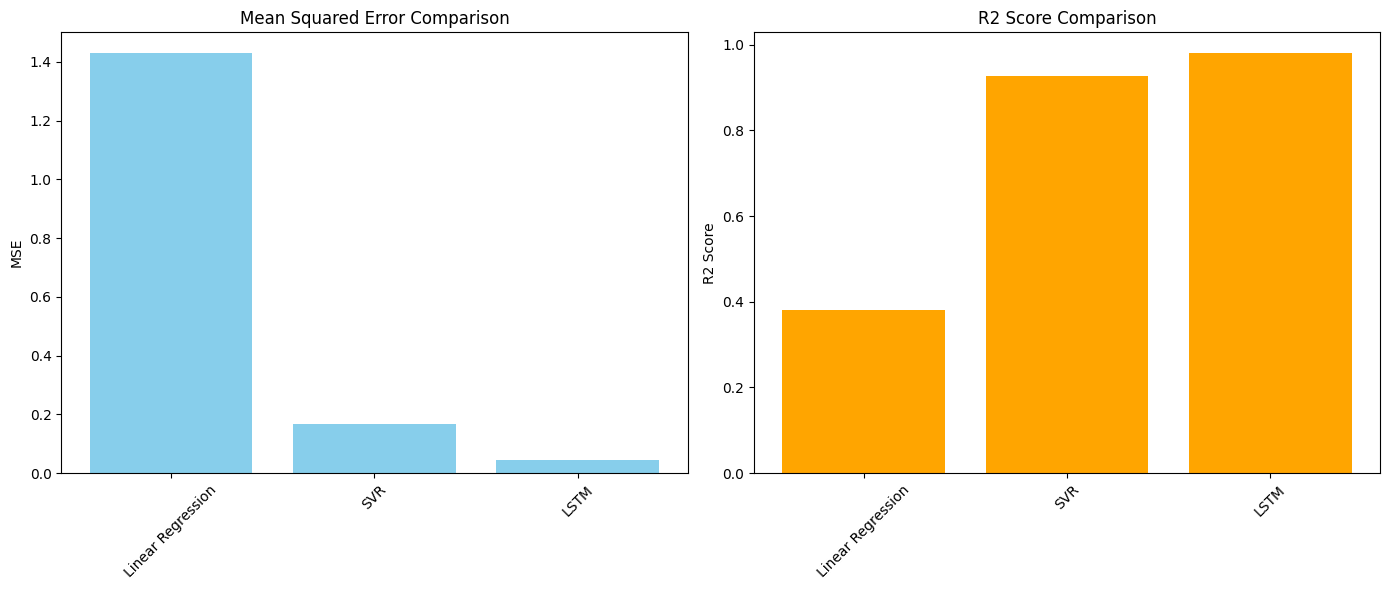

Model Performance:
Linear Regression: MSE = 1.4293, R2 = 0.3805
SVR: MSE = 0.1662, R2 = 0.9280
LSTM: MSE = 0.0461, R2 = 0.9800


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load and preprocess data
def preprocess_data(hh_data, veh_data, trip_data):
    # Merge datasets
    ev_data = pd.merge(
        veh_data[veh_data['VEHFUEL'] == 1],  # Assuming 1 represents EVs
        trip_data[['HOUSEID', 'TRIPID', 'TDAYDATE', 'TRPMILES']],
        on='HOUSEID'
    )

    # Engineering features
    ev_data['battery_capacity'] = np.random.uniform(40, 100, len(ev_data))  # kWh
    ev_data['initial_soc'] = np.random.uniform(0.1, 0.9, len(ev_data))  # %
    ev_data['charging_power'] = np.random.uniform(3.3, 150, len(ev_data))  # kW
    ev_data['distance'] = ev_data['TRPMILES'] * 1.60934  # Convert miles to km
    ev_data['arrival_time'] = np.random.randint(0, 24, len(ev_data))  # Synthetic hours of arrival

    # Target variables
    ev_data['energy_required'] = ev_data['battery_capacity'] * (1 - ev_data['initial_soc'])
    ev_data['charging_time'] = ev_data['energy_required'] / ev_data['charging_power']

    return ev_data

# LSTM Model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(50, activation='relu'),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
    return model

# Train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test):
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)

    # SVR
    svr = SVR(kernel='rbf', C=100, epsilon=0.1)
    svr.fit(X_train, y_train)
    y_pred_svr = svr.predict(X_test)
    mse_svr = mean_squared_error(y_test, y_pred_svr)
    r2_svr = r2_score(y_test, y_pred_svr)

    # LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    lstm = create_lstm_model((X_train.shape[1], 1))
    history = lstm.fit(
        X_train_lstm, y_train,
        validation_data=(X_test_lstm, y_test),
        epochs=150, batch_size=32, verbose=1
    )
    y_pred_lstm = lstm.predict(X_test_lstm)
    mse_lstm = mean_squared_error(y_test, y_pred_lstm)
    r2_lstm = r2_score(y_test, y_pred_lstm)

    # Plot Validation Loss and Accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Validation Loss for LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return {
        'Linear Regression': (mse_lr, r2_lr),
        'SVR': (mse_svr, r2_svr),
        'LSTM': (mse_lstm, r2_lstm)
    }

# Main execution
def main():
    # Load datasets
    hh_data = pd.read_csv("/content/dataset/hhv2pub.csv")
    veh_data = pd.read_csv("/content/dataset/vehv2pub.csv")
    trip_data = pd.read_csv("/content/dataset/tripv2pub.csv")

    # Preprocess data
    ev_data = preprocess_data(hh_data, veh_data, trip_data)

    # Prepare features and targets
    X = ev_data[['battery_capacity', 'initial_soc', 'charging_power', 'distance']].values
    y = ev_data['charging_time'].values

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    results = train_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

    # Visualization of comparison
    model_names = list(results.keys())
    mse_values = [results[model][0] for model in model_names]
    r2_values = [results[model][1] for model in model_names]

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.bar(model_names, mse_values, color='skyblue')
    plt.title('Mean Squared Error Comparison')
    plt.ylabel('MSE')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.bar(model_names, r2_values, color='orange')
    plt.title('R2 Score Comparison')
    plt.ylabel('R2 Score')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print("Model Performance:")
    for model, metrics in results.items():
        print(f"{model}: MSE = {metrics[0]:.4f}, R2 = {metrics[1]:.4f}")

if __name__ == "__main__":
    main()
